In [56]:
import pandas as pd

# Charger les articles
articles = pd.read_json("C:/Users/GENIUS ELECTRONICS/Desktop/Detec-Biais-nlp/data/Processed/polarite_cameroun_rss.json")

# Charger le lexique
lexique = pd.read_csv("C:/Users/GENIUS ELECTRONICS/Desktop/Detec-Biais-nlp/data/lexique_emotionnel.csv", encoding="utf-8")
lexique['mot'] = lexique['mot'].str.lower()

# Dictionnaires pour recherche rapide
pol_dict = dict(zip(lexique['mot'], lexique['polarité']))
emo_dict = dict(zip(lexique['mot'], lexique['émotion']))


In [66]:
from collections import Counter

def analyse_emotionnelle(tokens):
    if not isinstance(tokens, list): return pd.Series([0, 0, 0, 0])
    tokens = [t.lower() for t in tokens]
    polarités = [pol_dict.get(t, None) for t in tokens]
    
    total = len(tokens)
    n_pos = polarités.count("positive")
    n_neg = polarités.count("negative")
    n_neutre = polarités.count("neutral")
    n_emo = n_pos + n_neg
    
    return pd.Series([
        n_emo / total if total else 0,
        n_pos / total if total else 0,
        n_neg / total if total else 0,
        n_neutre / total if total else 0,
    ])

articles[[
    "proportion_émotion",
    "proportion_positive",
    "proportion_négative",
    "proportion_neutre"
]] = articles['tokens_Texte'].apply(analyse_emotionnelle)

def detect_polarities(tokens):
    if not isinstance(tokens, list): return []
    return [pol_dict.get(t.lower()) for t in tokens if pol_dict.get(t.lower())]

articles["polarités"] = articles["tokens_Texte"].apply(detect_polarities)



In [41]:
import unicodedata
import re

def clean_token(token):
    # Normalise les accents (œ, é, etc.)
    token = unicodedata.normalize('NFKD', token)
    token = ''.join([c for c in token if not unicodedata.combining(c)])
    token = token.lower()
    token = re.sub(r"[^\w\s]", "", token)  # supprime ponctuation
    return token.strip()




In [69]:
import spacy
nlp = spacy.load("fr_core_news_sm")

def lemmatise_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

articles["lemmas_Texte"] = articles["tokens_Texte"].apply(lemmatise_tokens)
def detect_emotions(tokens):
    if not isinstance(tokens, list): return []
    tokens = [t.lower() for t in tokens]
    emotions = [emo_dict.get(t) for t in tokens if emo_dict.get(t) not in [None, "neutre"]]
    return emotions
articles["émotions"] = articles["tokens_Texte"].apply(detect_emotions)

articles["Date"] = pd.to_datetime(articles["Date"], errors="coerce")
articles["Mois"] = articles["Date"].dt.to_period("M").astype(str)  # ou "W" pour semaine





C:\Users\GENIUS ELECTRONICS\AppData\Local\Temp\ipykernel_13028\1645140040.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  articles["Mois"] = articles["Date"].dt.to_period("M").astype(str)  # ou "W" pour semaine


In [63]:
from collections import defaultdict

emotion_counts = defaultdict(Counter)

for _, row in articles.iterrows():
    media = row["Nom du média"]
    for emotion in row["émotions"]:
        emotion_counts[media][emotion] += 1

# Convertir en DataFrame
emotion_df = pd.DataFrame(emotion_counts).fillna(0).T  # transposé pour avoir médias en lignes
emotion_df = emotion_df.astype(int)
emotion_df.head()


,joie,colère
VOA Afrique,3,0
BBC,6,4
Alwihda Info,8,3
Editions Le Pays,8,5
Journalducameroun.com,43,30


In [ ]:
from collections import defaultdict

emo_over_time = defaultdict(Counter)

for _, row in articles.iterrows():
    mois = row.get("Mois")
    if not mois:
        continue
    for emo in row.get("émotions", []):
        emo_over_time[mois][emo] += 1

# Conversion en DataFrame
emo_time_df = pd.DataFrame(emo_over_time).fillna(0).T.sort_index()
emo_time_df = emo_time_df.astype(int)
emotion_df_norm = emotion_df.div(emotion_df.sum(axis=1), axis=0)


In [74]:
from collections import defaultdict, Counter

emotion_counts = defaultdict(Counter)

for _, row in articles.iterrows():
    media = row.get("Nom du média", "Inconnu")
    for emotion in row.get("émotions", []):
        emotion_counts[media][emotion] += 1

 # Transformation en DataFrame
emotion_df = pd.DataFrame(emotion_counts).fillna(0).T  # médias = lignes
emotion_df = emotion_df.astype(int)

# Normalisation par ligne (chaque média)
emotion_df_norm = emotion_df.div(emotion_df.sum(axis=1), axis=0)
       


In [67]:
from collections import Counter
from itertools import product

# Créer des paires (émotion, polarité)
emotion_polarity_counts = Counter()

for _, row in articles.iterrows():
    emos = row.get("émotions", [])
    pols = row.get("polarités", [])
    for emo, pol in product(emos, pols):
        emotion_polarity_counts[(emo, pol)] += 1

# Convertir en DataFrame
cross_df = pd.DataFrame.from_dict(emotion_polarity_counts, orient="index", columns=["count"])
cross_df.index = pd.MultiIndex.from_tuples(cross_df.index, names=["émotion", "polarité"])
cross_df = cross_df.reset_index()
pivot = cross_df.pivot(index="émotion", columns="polarité", values="count").fillna(0).astype(int)


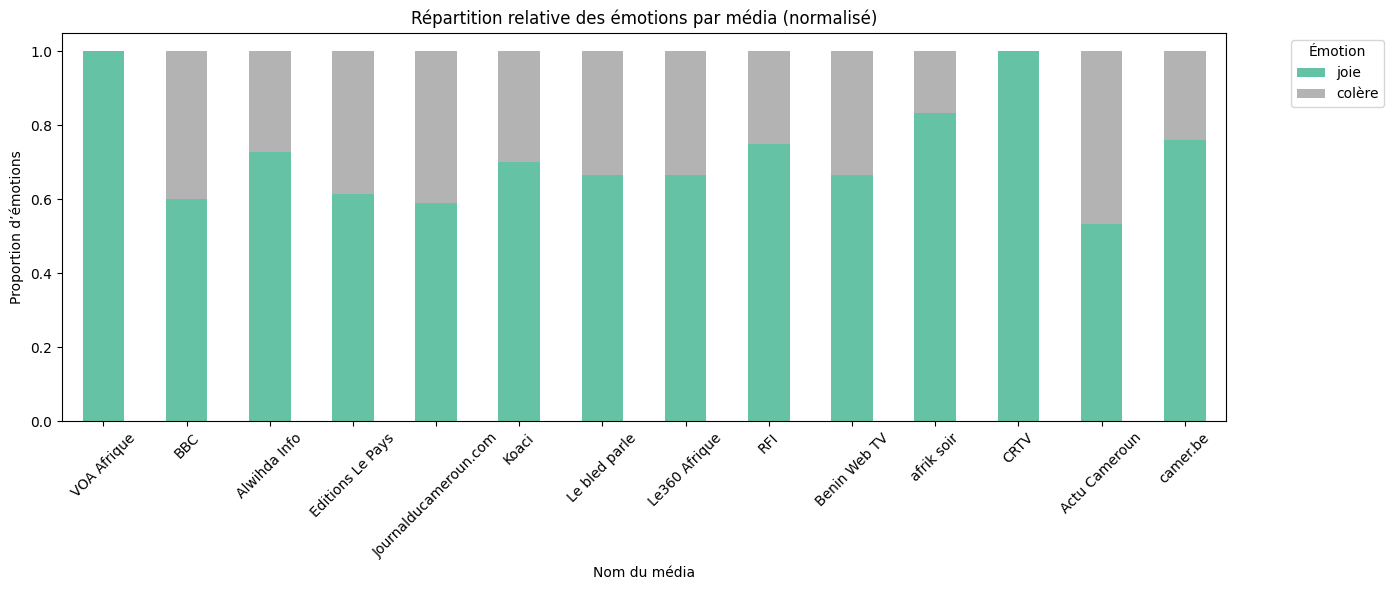

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
emotion_df_norm.plot(kind="bar", stacked=True, figsize=(14, 6), colormap="Set2")
plt.title("Répartition relative des émotions par média (normalisé)")
plt.ylabel("Proportion d’émotions")
plt.xlabel("Nom du média")
plt.xticks(rotation=45)
plt.legend(title="Émotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


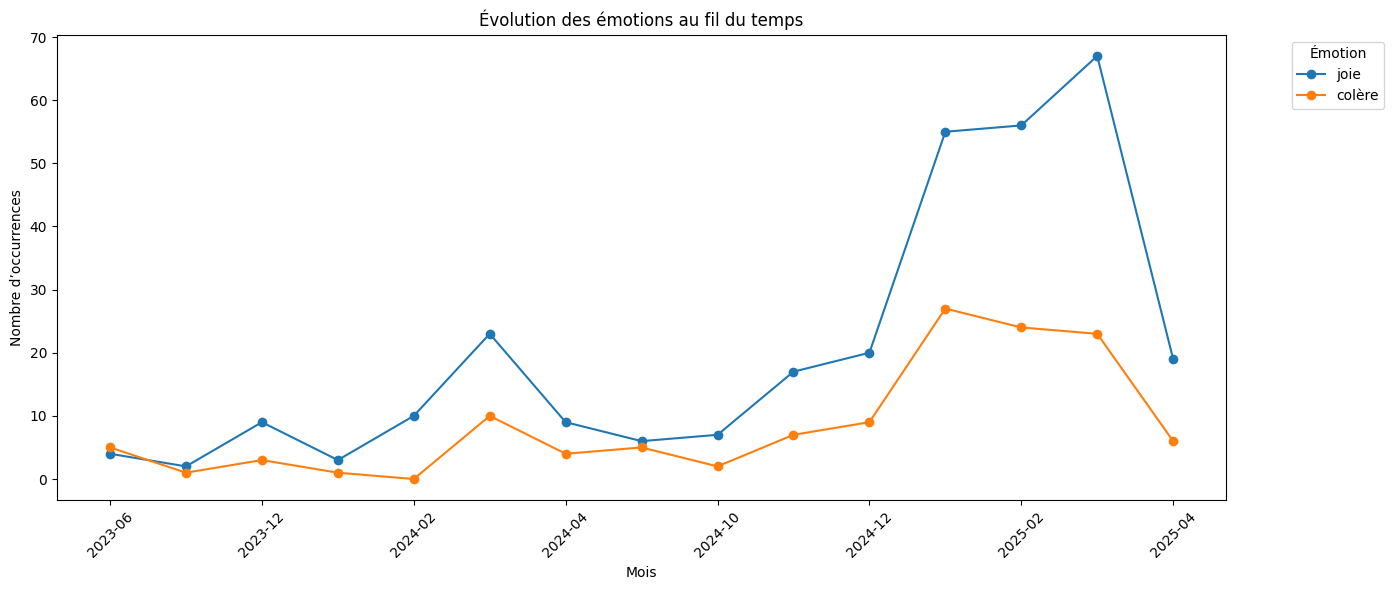

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
emo_time_df.plot(figsize=(14, 6), marker='o')
plt.title("Évolution des émotions au fil du temps")
plt.xlabel("Mois")
plt.ylabel("Nombre d’occurrences")
plt.xticks(rotation=45)
plt.legend(title="Émotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


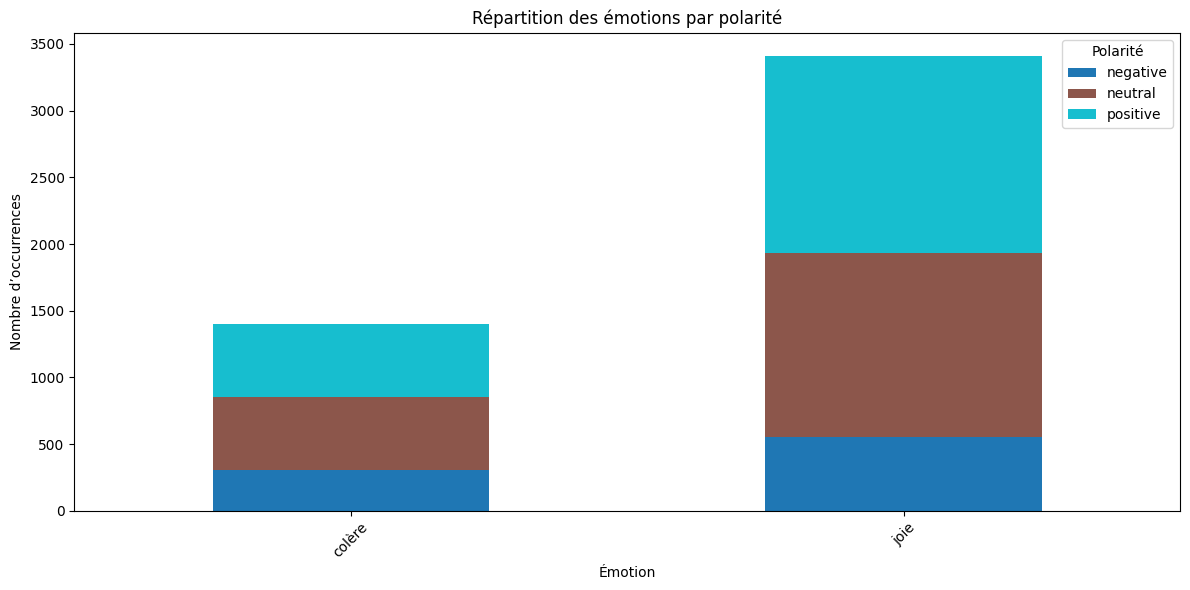

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
pivot.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")
plt.title("Répartition des émotions par polarité")
plt.xlabel("Émotion")
plt.ylabel("Nombre d’occurrences")
plt.xticks(rotation=45)
plt.legend(title="Polarité")
plt.tight_layout()
plt.show()


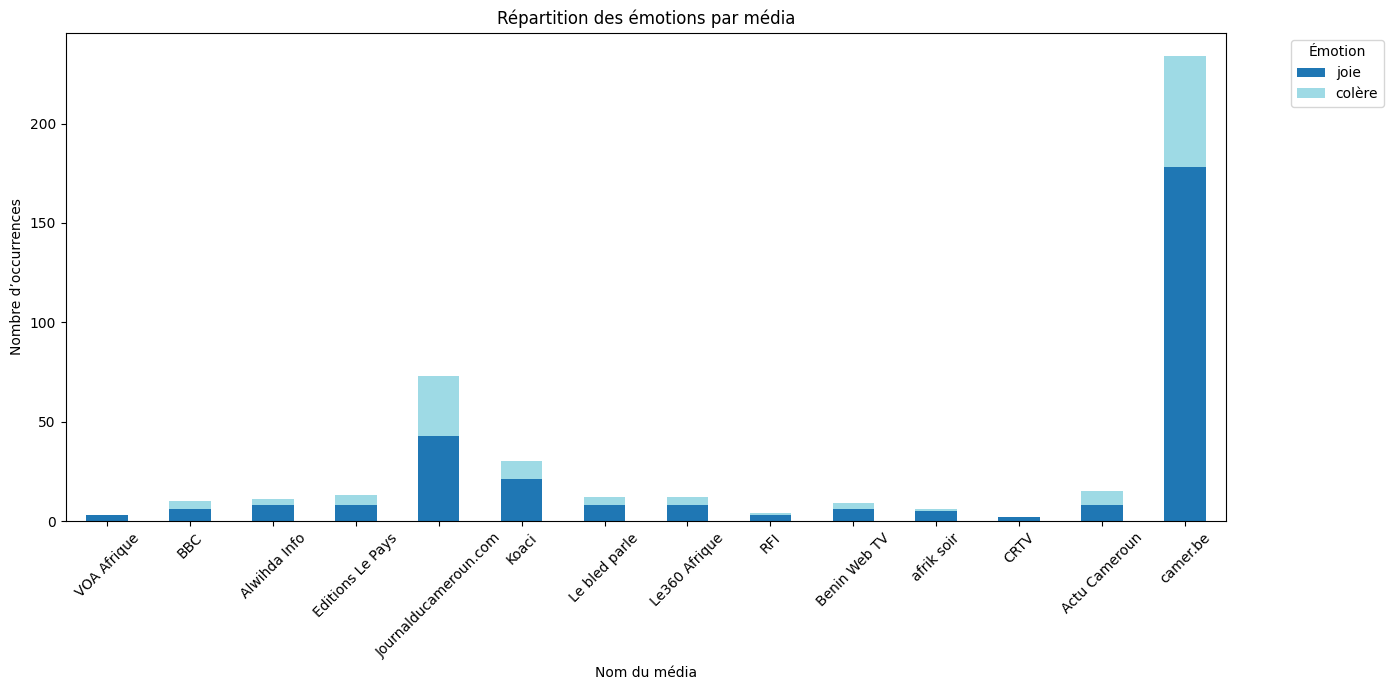

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

emotion_df.plot(kind="bar", stacked=True, figsize=(14, 7), colormap="tab20")
plt.title("Répartition des émotions par média")
plt.ylabel("Nombre d’occurrences")
plt.xlabel("Nom du média")
plt.xticks(rotation=45)
plt.legend(title="Émotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [58]:
articles.groupby("Nom du média")[["proportion_positive", "proportion_négative"]].mean().sort_values("proportion_négative", ascending=False)

,proportion_positive,proportion_négative
Nom du média,,
Editions Le Pays,0.492063,0.325397
Actu Cameroun,0.428571,0.321429
BBC,0.380952,0.253968
Benin Web TV,0.500000,0.250000
Le bled parle,0.441558,0.233766
Le360 Afrique,0.472222,0.229167
Journalducameroun.com,0.299620,0.211763
Alwihda Info,0.472222,0.173611
Koaci,0.400926,0.167989


In [59]:
articles.groupby("Thème")[["proportion_positive", "proportion_négative"]].mean()


,proportion_positive,proportion_négative
Thème,,
politique,0.411447,0.171822


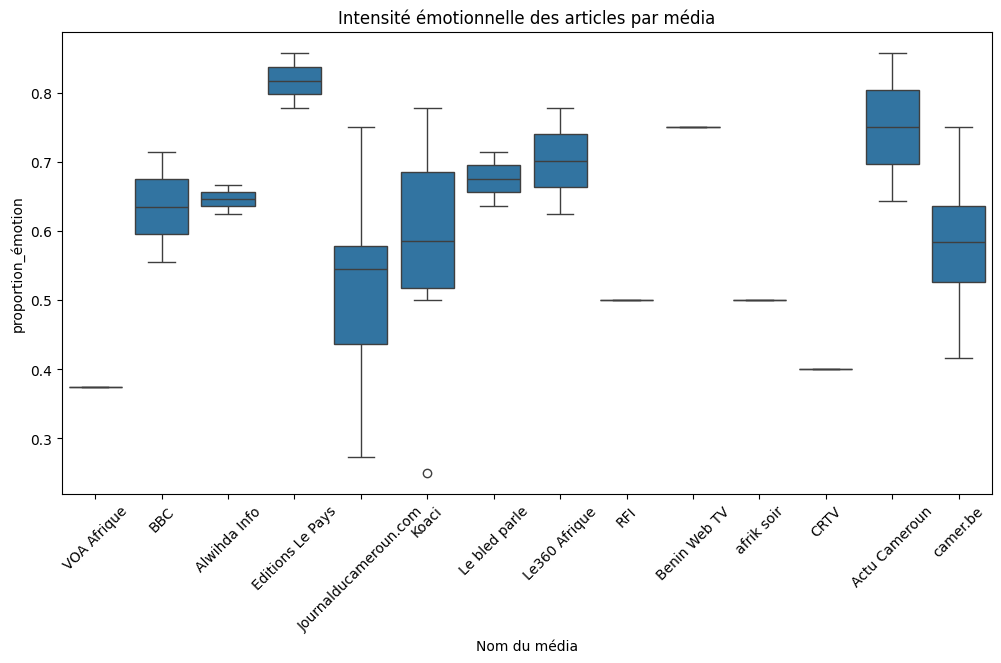

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=articles, x="Nom du média", y="proportion_émotion")
plt.xticks(rotation=45)
plt.title("Intensité émotionnelle des articles par média")
plt.show()


In [53]:
articles.sort_values("proportion_émotion", ascending=False).head(10)[["Titre", "proportion_émotion", "Nom du média", "Thème"]]


,Titre,proportion_émotion,Nom du média,Thème
68,Présidentielle 2025 au Cameroun : Franck Biya ...,0.090909,camer.be,politique
17,Cameroun-présidentielle 2025 : Mgr Samuel Kled...,0.083333,Journalducameroun.com,politique
46,Actualités CAMEROUN :: Présidentielle 2025 : L...,0.083333,camer.be,politique
67,Actualités CAMEROUN :: Présidentielle 2025 : L...,0.083333,camer.be,politique
57,Actualités CAMEROUN :: Appel à l’Unité du Gran...,0.076923,camer.be,politique
1,Présidentielle 2025 au Cameroun : L’Eglise Cat...,0.000000,BBC,politique
0,Présidentielle 2025 au Cameroun : les grandes ...,0.000000,VOA Afrique,politique
6,Présidentielle 2025 : Orange Cameroun dit non ...,0.000000,Le bled parle,politique
5,"Cameroun : Présidentielle 2025, le casse-tête ...",0.000000,Koaci,politique
4,Cameroun : risque d’implosion avant l’élection...,0.000000,Journalducameroun.com,politique
